# Data

In [1]:
import ast
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import metrics 

In [2]:
# USDC: baseCurrency:  "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"
# USDT: baseCurrency:  "0xdac17f958d2ee523a2206206994597c13d831ec7"
# quoteCurrency:  "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"

# A simple function to use requests.post to make the API call.
def run_query(query):  
    headers = {'X-API-KEY': 'BQYjLXSsm32NnV6FM4eudu9xYt2L3AsW'}
    request = requests.post('https://graphql.bitquery.io/',
                            json={'query': query}, headers=headers)
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed and return code is {}.      {}'.format(request.status_code,
                        query))

# The GraphQL query
query = """
query
{
  ethereum(network: ethereum) {
    dexTrades(
      options: {limit: 100000, asc: "timeInterval.minute"}
      date: {since: "2021-04-21"}
      exchangeName: {is: "Uniswap"}
      baseCurrency: {is: "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"}
      quoteCurrency: {is: "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"}
    ) {
      timeInterval {
        minute(count: 5)
      }
      baseCurrency {
        symbol
        address
      }
      baseAmount
      quoteCurrency {
        symbol
        address
      }
      quoteAmount
      trades: count
      quotePrice
      maximum_price: quotePrice(calculate: maximum)
      minimum_price: quotePrice(calculate: minimum)
      open_price: minimum(of: block, get: quote_price)
      close_price: maximum(of: block, get: quote_price)
    }
  }
}

"""
# Execute the query
result = run_query(query)  

#Build dataframe
data=pd.DataFrame(result['data']['ethereum']['dexTrades'])

#Data Cleaning, Feature Engineering
data= data.dropna()

time=[]
for x in range(0, data.shape[0]):
    time.append(data['timeInterval'].iloc[x]['minute'])  
data['timeInterval']= time

data['close_price']= data['close_price'].apply(lambda x: float(x))
data=data.set_index('timeInterval')
data.index=pd.to_datetime(data.index)
print(data.shape)
data.tail(2)

(8519, 10)


,baseCurrency,baseAmount,quoteCurrency,quoteAmount,trades,quotePrice,maximum_price,minimum_price,open_price,close_price
timeInterval,,,,,,,,,,
2021-05-20 13:45:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",615354.430293,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",212.253051,24,0.000345,0.000348,0.000343,0.0003452047208650858,0.000345
2021-05-20 13:50:00,"{'symbol': 'USDC', 'address': '0xa0b86991c6218...",927562.144442,"{'symbol': 'WETH', 'address': '0xc02aaa39b223f...",318.420272,37,0.000343,0.000345,0.000342,0.00034291689783181445,0.000343


# EMA  BollingerBands 

In [3]:
def getEMABollingerBands (df):    
    # Calculate EMA & std
    EMA= df['quotePrice'].ewm(span=20).mean()
    std= df['quotePrice'].ewm(span=20).std()    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (EMA - 1.5* 2 * std).abs()
    df['bearish_upper'] = EMA +  2 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (EMA - 2 * std).abs()
    df['neutral_upper'] = EMA + 2 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (EMA - 2 * std).abs()
    df['bullish_upper'] = EMA + 1.5 * 2 * std
    
    df.dropna(inplace=True)
    
    
    df=df[['quotePrice','bearish_lower','bearish_upper','neutral_lower','neutral_upper','bullish_lower', 'bullish_upper']]
    df=df.rename(columns={'quotePrice':'current _price'})    
    return df

copied_data=data.copy()
data_bands=getEMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test



data_final_EMA= test_set.copy()

for col in test_set.columns:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model.add(Dropout(0.2))
    model.add(Dense(units=1 ))  # tedade noroun ha
    model.add(Activation('linear'))  #activation ra besoorate layer joda add konim natije behtar ast
    model.compile(loss='mse', optimizer='adam') 
    
    model.fit(X_train,y_train,epochs=30,batch_size=32, verbose=1) 
    
    prediction=model.predict(X_test).squeeze()
    
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_EMA= data_final_EMA.join(predicted)

data_final_EMA

Epoch 1/30
187/187 [==============================] - 2s 4ms/step - loss: 5.2880e-05
Epoch 2/30
187/187 [==============================] - 1s 4ms/step - loss: 2.0289e-05
Epoch 3/30
187/187 [==============================] - 1s 4ms/step - loss: 1.6827e-05
Epoch 4/30
187/187 [==============================] - 1s 4ms/step - loss: 1.5720e-05
Epoch 5/30
187/187 [==============================] - 1s 4ms/step - loss: 1.4653e-05
Epoch 6/30
187/187 [==============================] - 1s 4ms/step - loss: 1.4569e-05
Epoch 7/30
187/187 [==============================] - 1s 4ms/step - loss: 1.4647e-05
Epoch 8/30
187/187 [==============================] - 1s 4ms/step - loss: 1.5025e-05
Epoch 9/30
187/187 [==============================] - 1s 4ms/step - loss: 1.5067e-05
Epoch 10/30
187/187 [==============================] - 1s 4ms/step - loss: 1.3844e-05
Epoch 11/30
187/187 [==============================] - 1s 5ms/step - loss: 1.4589e-05
Epoch 12/30
187/187 [==============================] - 1s 5ms/s

187/187 [==============================] - 1s 3ms/step - loss: 1.7310e-06
Epoch 7/30
187/187 [==============================] - 1s 3ms/step - loss: 1.4699e-06
Epoch 8/30
187/187 [==============================] - 1s 3ms/step - loss: 1.5200e-06
Epoch 9/30
187/187 [==============================] - 1s 3ms/step - loss: 1.2210e-06
Epoch 10/30
187/187 [==============================] - 1s 3ms/step - loss: 1.3607e-06
Epoch 11/30
187/187 [==============================] - 1s 3ms/step - loss: 1.1048e-06
Epoch 12/30
187/187 [==============================] - 1s 3ms/step - loss: 1.2056e-06
Epoch 13/30
187/187 [==============================] - 1s 3ms/step - loss: 1.1472e-06
Epoch 14/30
187/187 [==============================] - 1s 3ms/step - loss: 1.0696e-06
Epoch 15/30
187/187 [==============================] - 1s 3ms/step - loss: 9.6852e-07
Epoch 16/30
187/187 [==============================] - 1s 3ms/step - loss: 1.0591e-06
Epoch 17/30
187/187 [==============================] - 1s 3ms/step - 

187/187 [==============================] - 1s 3ms/step - loss: 1.9297e-06
Epoch 12/30
187/187 [==============================] - 1s 3ms/step - loss: 2.3495e-06
Epoch 13/30
187/187 [==============================] - 1s 3ms/step - loss: 2.1784e-06
Epoch 14/30
187/187 [==============================] - 1s 3ms/step - loss: 1.9759e-06
Epoch 15/30
187/187 [==============================] - 1s 3ms/step - loss: 2.1806e-06
Epoch 16/30
187/187 [==============================] - 1s 3ms/step - loss: 2.2710e-06A: 0s - loss: 2.31
Epoch 17/30
187/187 [==============================] - 1s 3ms/step - loss: 2.1384e-06
Epoch 18/30
187/187 [==============================] - 1s 3ms/step - loss: 1.9154e-06
Epoch 19/30
187/187 [==============================] - 1s 3ms/step - loss: 1.9145e-06
Epoch 20/30
187/187 [==============================] - 1s 3ms/step - loss: 2.2026e-06
Epoch 21/30
187/187 [==============================] - 1s 3ms/step - loss: 2.6097e-06
Epoch 22/30
187/187 [===========================

,current _price,bearish_lower,bearish_upper,neutral_lower,neutral_upper,bullish_lower,bullish_upper,predicted_current _price,predicted_bearish_lower,predicted_bearish_upper,predicted_neutral_lower,predicted_neutral_upper,predicted_bullish_lower,predicted_bullish_upper
timeInterval,,,,,,,,,,,,,,
2021-05-11 17:00:00,0.000248,0.000244,0.000252,0.000245,0.000252,0.000245,0.000254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:05:00,0.000248,0.000244,0.000252,0.000245,0.000252,0.000245,0.000253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:10:00,0.000249,0.000244,0.000252,0.000246,0.000252,0.000246,0.000253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:15:00,0.000249,0.000244,0.000252,0.000246,0.000252,0.000246,0.000253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:20:00,0.000249,0.000244,0.000251,0.000246,0.000251,0.000246,0.000253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20 13:30:00,0.000337,0.000311,0.000372,0.000323,0.000372,0.000323,0.000384,0.000336,0.000311,0.000373,0.000323,0.000373,0.000323,0.000385
2021-05-20 13:35:00,0.000342,0.000312,0.000371,0.000324,0.000371,0.000324,0.000382,0.000337,0.000310,0.000371,0.000322,0.000371,0.000322,0.000384
2021-05-20 13:40:00,0.000345,0.000313,0.000369,0.000325,0.000369,0.000325,0.000381,0.000342,0.000313,0.000369,0.000324,0.000370,0.000324,0.000381


In [4]:
data_EMA=data_final_EMA[5:].copy()

def bearish_range(x):
    return str(x['bearish_lower']) + ' to ' + str(x['bearish_upper'])
def neutral_range(x):
    return str(x['neutral_lower']) + ' to ' + str(x['neutral_upper'])
def bullish_range(x):
    return str(x['bullish_lower']) + ' to ' + str(x['bullish_upper'])


def predicted_bearish_range(x):
    return str(x['predicted_bearish_lower']) + ' to ' + str(x['predicted_bearish_upper'])
def predicted_neutral_range(x):
    return str(x['predicted_neutral_lower']) + ' to ' + str(x['predicted_neutral_upper'])
def predicted_bullish_range(x):
    return str(x['predicted_bullish_lower']) + ' to ' + str(x['predicted_bullish_upper'])


data_EMA['Bearish Liquidity Range']= data_EMA.apply(bearish_range, axis=1)
data_EMA['Neutral Liquidity Range']= data_EMA.apply(neutral_range, axis=1)
data_EMA['Bullish Liquidity Range']= data_EMA.apply(bullish_range, axis=1)

data_EMA['Predicted Bearish Liquidity Range']= data_EMA.apply(predicted_bearish_range, axis=1)
data_EMA['Predicted Neutral Liquidity Range']= data_EMA.apply(predicted_neutral_range, axis=1)
data_EMA['Predicted Bullish Liquidity Range']= data_EMA.apply(predicted_bullish_range, axis=1)

data_EMA=data_EMA[['current _price', 'Bearish Liquidity Range','Neutral Liquidity Range', 
                         'Bullish Liquidity Range','predicted_current _price',  'Predicted Bearish Liquidity Range',
                         'Predicted Neutral Liquidity Range','Predicted Bullish Liquidity Range']]

data_EMA

,current _price,Bearish Liquidity Range,Neutral Liquidity Range,Bullish Liquidity Range,predicted_current _price,Predicted Bearish Liquidity Range,Predicted Neutral Liquidity Range,Predicted Bullish Liquidity Range
timeInterval,,,,,,,,
2021-05-11 17:25:00,0.000249,0.0002446646162938027 to 0.0002512964918167699,0.0002459909913983961 to 0.0002512964918167699,0.0002459909913983961 to 0.00025262286692136334,0.000249,0.00024473333033565224 to 0.00025116383830954146,0.00024594698441961574 to 0.0002513740549423024,0.00024586531571023243 to 0.00025284612528682316
2021-05-11 17:30:00,0.000249,0.000244857776743303 to 0.00025116597042999875,0.0002461194154806421 to 0.00025116597042999875,0.0002461194154806421 to 0.0002524276091673379,0.000249,0.00024493241030866455 to 0.00025102492558756593,0.00024607785315404707 to 0.00025123230867216253,0.00024599578311643004 to 0.0002526463841257027
2021-05-11 17:35:00,0.000247,0.0002447461947755299 to 0.00025104009042899573,0.00024600497390622305 to 0.00025104009042899573,0.00024600497390622305 to 0.0002522988695596889,0.000249,0.0002451168884043623 to 0.0002508965851384057,0.0002461986862457958 to 0.0002511050970718826,0.0002461177267272267 to 0.00025245579452649576
2021-05-11 17:40:00,0.000247,0.00024453724220228895 to 0.00025094005207670537,0.00024581780417717224 to 0.00025094005207670537,0.00024581780417717224 to 0.00025222061405158865,0.000247,0.0002448178235393666 to 0.000250776537692848,0.0002459428672999908 to 0.00025098770006715376,0.0002458681157006673 to 0.0002523687751174024
2021-05-11 17:45:00,0.000248,0.00024464565937309935 to 0.0002507856168194535,0.00024587365086237015 to 0.0002507856168194535,0.00024587365086237015 to 0.0002520136083087243,0.000247,0.0002445267365853294 to 0.0002506906815481165,0.0002456824437749479 to 0.00025090143630822364,0.00024561151834702873 to 0.00025232663954346147
...,...,...,...,...,...,...,...,...
2021-05-20 13:30:00,0.000337,0.0003109649571100484 to 0.0003721545066060026,0.0003232028670092393 to 0.0003721545066060026,0.0003232028670092393 to 0.0003843924165051935,0.000336,0.00031064017984449335 to 0.00037255649213577903,0.0003227795971208843 to 0.0003729348365037059,0.00032282716232306886 to 0.00038545540955376936
2021-05-20 13:35:00,0.000342,0.0003119068576879196 to 0.00037067184814486585,0.0003236598557793088 to 0.00037067184814486585,0.0003236598557793088 to 0.0003824248462362551,0.000337,0.0003103958867893817 to 0.00037110189841494876,0.0003222852506243182 to 0.00037147149019077014,0.00032232819841929313 to 0.00038375155073974764
2021-05-20 13:40:00,0.000345,0.0003133064497602418 to 0.000369334521537672,0.0003245120641157278 to 0.000369334521537672,0.0003245120641157278 to 0.000380540135893158,0.000342,0.00031255275551049587 to 0.0003694732858302352,0.0003236814479562168 to 0.00036985572351196474,0.00032368179997113 to 0.0003813589779725363


# SMA  BollingerBands 

In [5]:
def getSMABollingerBands (df):    
    # Calculate SMA & std (window=20, no_of_std=2)
    SMA= df['quotePrice'].rolling(window=20).mean()
    std= df['quotePrice'].rolling(window=20).std()
    
    # Calculate the upper and lower Bearish Bollinger Bands
    df['bearish_lower'] = (SMA - 1.5* 2 * std).abs()
    df['bearish_upper'] = SMA +  2 * std  
    # Calculate the upper and lower Neutral Bollinger Bands
    df['neutral_lower'] = (SMA - 2 * std).abs()
    df['neutral_upper'] = SMA + 2 * std
    # Calculate the upper and lower Bullish Bollinger Bands
    df['bullish_lower'] = (SMA - 2 * std).abs()
    df['bullish_upper'] = SMA + 1.5 * 2 * std
    
    df.dropna(inplace=True)
    
    df=df[['quotePrice','bearish_lower','bearish_upper','neutral_lower','neutral_upper','bullish_lower', 'bullish_upper']]
    df=df.rename(columns={'quotePrice':'current _price'})    
    return df


copied_data=data.copy()
data_bands=getSMABollingerBands (copied_data)


def train_test_split(df, test_size):
    split = df.shape[0] - int(test_size * df.shape[0])
    train_set = df.iloc[:split]
    test_set = df.iloc[split:]
    return train_set, test_set

train_set, test_set = train_test_split(data_bands, 0.3)


def zero_scaling(df):   
    return df / df.iloc[0] - 1


def sliding_window(df, len_window, zero):   
    window = []
    for a in range(df.shape[0] - len_window):
        sub = df[a: (a + len_window)].copy()
        if zero:
            sub = zero_scaling(sub)
        window.append(sub.values)
    return np.array(window)


def prepare_data(column, len_window, zero):     
    train_data = train_set[[column]]
    test_data = test_set[[column]]  
    
    X_train = sliding_window(train_data, len_window, zero)  
    X_test = sliding_window(test_data, len_window, zero) 
    
    y_train = train_data[column][len_window:].values
    y_test = test_data[column][len_window:].values
    
    if zero:
        y_train = y_train / train_data[column][:-len_window].values - 1
        y_test = y_test / test_data[column][:-len_window].values - 1
        
    return train_data,  test_data, X_train, X_test,  y_train, y_test


data_final_SMA= test_set.copy()

for col in test_set.columns:
    train_data,  test_data, X_train, X_test,  y_train, y_test = prepare_data(column=col, len_window=5, zero=True)
    
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(X_train.shape[1], X_train.shape[2])) )  
    model.add(Dropout(0.2))
    model.add(Dense(units=1 ))  # tedade noroun ha
    model.add(Activation('linear'))  #activation ra besoorate layer joda add konim natije behtar ast
    model.compile(loss='mse', optimizer='adam') 
    
    model.fit(X_train,y_train,epochs=30,batch_size=32, verbose=1) 
    
    prediction=model.predict(X_test).squeeze()
    
    predicted= pd.DataFrame(data=(prediction + 1) * (test_data[col][:-5].values) ,  index=test_data[5:].index ,columns=['predicted_'+col] )            

    data_final_SMA= data_final_SMA.join(predicted)

data_final_SMA

Epoch 1/30
186/186 [==============================] - 2s 3ms/step - loss: 5.5826e-05
Epoch 2/30
186/186 [==============================] - 1s 3ms/step - loss: 2.0891e-05
Epoch 3/30
186/186 [==============================] - 1s 3ms/step - loss: 1.6204e-05
Epoch 4/30
186/186 [==============================] - 1s 3ms/step - loss: 1.4643e-05
Epoch 5/30
186/186 [==============================] - 1s 3ms/step - loss: 1.4979e-05
Epoch 6/30
186/186 [==============================] - 1s 3ms/step - loss: 1.3493e-05
Epoch 7/30
186/186 [==============================] - 1s 5ms/step - loss: 1.4372e-05
Epoch 8/30
186/186 [==============================] - 1s 3ms/step - loss: 1.4095e-05
Epoch 9/30
186/186 [==============================] - 1s 3ms/step - loss: 1.4039e-05
Epoch 10/30
186/186 [==============================] - 1s 3ms/step - loss: 1.4692e-05
Epoch 11/30
186/186 [==============================] - 1s 5ms/step - loss: 1.4143e-05
Epoch 12/30
186/186 [==============================] - 1s 4ms/s

186/186 [==============================] - 1s 4ms/step - loss: 1.9337e-06
Epoch 7/30
186/186 [==============================] - 1s 3ms/step - loss: 1.6711e-06
Epoch 8/30
186/186 [==============================] - 1s 3ms/step - loss: 1.7195e-06
Epoch 9/30
186/186 [==============================] - 1s 3ms/step - loss: 1.3015e-06
Epoch 10/30
186/186 [==============================] - 1s 3ms/step - loss: 1.2901e-06
Epoch 11/30
186/186 [==============================] - 1s 3ms/step - loss: 1.2073e-06
Epoch 12/30
186/186 [==============================] - 1s 3ms/step - loss: 1.1723e-06
Epoch 13/30
186/186 [==============================] - 1s 3ms/step - loss: 1.3149e-06
Epoch 14/30
186/186 [==============================] - 1s 3ms/step - loss: 1.0244e-06
Epoch 15/30
186/186 [==============================] - 1s 3ms/step - loss: 1.0525e-06
Epoch 16/30
186/186 [==============================] - 1s 3ms/step - loss: 1.0365e-06
Epoch 17/30
186/186 [==============================] - 1s 4ms/step - 

186/186 [==============================] - 1s 3ms/step - loss: 2.3811e-06
Epoch 12/30
186/186 [==============================] - 1s 3ms/step - loss: 2.0865e-06
Epoch 13/30
186/186 [==============================] - 1s 3ms/step - loss: 2.2709e-06
Epoch 14/30
186/186 [==============================] - 1s 3ms/step - loss: 2.2690e-06
Epoch 15/30
186/186 [==============================] - 1s 3ms/step - loss: 2.2354e-06
Epoch 16/30
186/186 [==============================] - 1s 3ms/step - loss: 1.9885e-06
Epoch 17/30
186/186 [==============================] - 1s 3ms/step - loss: 2.1063e-06
Epoch 18/30
186/186 [==============================] - 1s 3ms/step - loss: 2.1146e-06
Epoch 19/30
186/186 [==============================] - 1s 3ms/step - loss: 2.0929e-06
Epoch 20/30
186/186 [==============================] - 1s 4ms/step - loss: 2.2420e-06
Epoch 21/30
186/186 [==============================] - 1s 3ms/step - loss: 1.9461e-06
Epoch 22/30
186/186 [==============================] - 1s 3ms/step

,current _price,bearish_lower,bearish_upper,neutral_lower,neutral_upper,bullish_lower,bullish_upper,predicted_current _price,predicted_bearish_lower,predicted_bearish_upper,predicted_neutral_lower,predicted_neutral_upper,predicted_bullish_lower,predicted_bullish_upper
timeInterval,,,,,,,,,,,,,,
2021-05-11 17:25:00,0.000249,0.000245,0.000250,0.000246,0.000250,0.000246,0.000252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:30:00,0.000249,0.000245,0.000250,0.000246,0.000250,0.000246,0.000251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:35:00,0.000247,0.000245,0.000250,0.000246,0.000250,0.000246,0.000251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:40:00,0.000247,0.000245,0.000250,0.000246,0.000250,0.000246,0.000251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-11 17:45:00,0.000248,0.000245,0.000250,0.000246,0.000250,0.000246,0.000251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-20 13:30:00,0.000337,0.000319,0.000370,0.000329,0.000370,0.000329,0.000380,0.000336,0.000318,0.000371,0.000328,0.000371,0.000329,0.000381
2021-05-20 13:35:00,0.000342,0.000319,0.000368,0.000329,0.000368,0.000329,0.000377,0.000337,0.000318,0.000369,0.000328,0.000368,0.000328,0.000379
2021-05-20 13:40:00,0.000345,0.000320,0.000366,0.000329,0.000366,0.000329,0.000375,0.000342,0.000319,0.000366,0.000328,0.000366,0.000329,0.000375


In [6]:
data_SMA=data_final_SMA[5:].copy()

def bearish_range(x):
    return str(x['bearish_lower']) + ' to ' + str(x['bearish_upper'])
def neutral_range(x):
    return str(x['neutral_lower']) + ' to ' + str(x['neutral_upper'])
def bullish_range(x):
    return str(x['bullish_lower']) + ' to ' + str(x['bullish_upper'])


def predicted_bearish_range(x):
    return str(x['predicted_bearish_lower']) + ' to ' + str(x['predicted_bearish_upper'])
def predicted_neutral_range(x):
    return str(x['predicted_neutral_lower']) + ' to ' + str(x['predicted_neutral_upper'])
def predicted_bullish_range(x):
    return str(x['predicted_bullish_lower']) + ' to ' + str(x['predicted_bullish_upper'])


data_SMA['Bearish Liquidity Range']= data_SMA.apply(bearish_range, axis=1)
data_SMA['Neutral Liquidity Range']= data_SMA.apply(neutral_range, axis=1)
data_SMA['Bullish Liquidity Range']= data_SMA.apply(bullish_range, axis=1)

data_SMA['Predicted Bearish Liquidity Range']= data_SMA.apply(predicted_bearish_range, axis=1)
data_SMA['Predicted Neutral Liquidity Range']= data_SMA.apply(predicted_neutral_range, axis=1)
data_SMA['Predicted Bullish Liquidity Range']= data_SMA.apply(predicted_bullish_range, axis=1)

data_SMA=data_SMA[['current _price', 'Bearish Liquidity Range','Neutral Liquidity Range', 
                         'Bullish Liquidity Range','predicted_current _price',  'Predicted Bearish Liquidity Range',
                         'Predicted Neutral Liquidity Range','Predicted Bullish Liquidity Range']]

data_SMA

,current _price,Bearish Liquidity Range,Neutral Liquidity Range,Bullish Liquidity Range,predicted_current _price,Predicted Bearish Liquidity Range,Predicted Neutral Liquidity Range,Predicted Bullish Liquidity Range
timeInterval,,,,,,,,
2021-05-11 17:50:00,0.000248,0.00024521587328290103 to 0.00024992888686240216,0.00024615847599880126 to 0.00024992888686240216,0.00024615847599880126 to 0.0002508714895783024,0.000248,0.0002449100114612893 to 0.00025009641103217,0.00024585952464272224 to 0.0002500128060244747,0.00024604147036796166 to 0.0002510082158169818
2021-05-11 17:55:00,0.000248,0.0002455928733677538 to 0.00024983779900885505,0.00024644185849597404 to 0.00024983779900885505,0.00024644185849597404 to 0.0002506867841370753,0.000248,0.00024543564654999216 to 0.0002499477912342907,0.0002462509522694138 to 0.00024986374628302004,0.00024642885025839324 to 0.00025070791781485474
2021-05-11 18:00:00,0.000247,0.00024569838861190197 to 0.0002498056811496879,0.0002465198471194591 to 0.0002498056811496879,0.0002465198471194591 to 0.00025062713965724504,0.000248,0.0002458514097685498 to 0.000249842368290273,0.00024657598966621884 to 0.0002497559595326291,0.000246747148569797 to 0.0002505023831891635
2021-05-11 18:05:00,0.000247,0.00024579278224521673 to 0.0002497771705536938,0.0002465896599069121 to 0.0002497771705536938,0.0002465896599069121 to 0.0002505740482153892,0.000247,0.00024575778543951436 to 0.00024984640580066246,0.0002465172212533582 to 0.0002497601183690333,0.0002466871439911492 to 0.0002505341144433845
2021-05-11 18:10:00,0.000247,0.00024582388763005094 to 0.0002497684093997295,0.0002466127919839867 to 0.0002497684093997295,0.0002466127919839867 to 0.00025055731375366524,0.000247,0.0002458155640118569 to 0.0002498312783975448,0.0002465469514675342 to 0.00024974642317241504,0.0002467170003646223 to 0.00025050256672876835
...,...,...,...,...,...,...,...,...
2021-05-20 13:30:00,0.000337,0.0003185648461548675 to 0.0003697652372883044,0.0003288049243815549 to 0.0003697652372883044,0.0003288049243815549 to 0.0003800053155149918,0.000336,0.0003179412963726681 to 0.00037079573211286305,0.0003283560215229402 to 0.0003706865561957355,0.0003287567321804163 to 0.00038130844468909296
2021-05-20 13:35:00,0.000342,0.00031897088910727757 to 0.0003676938174180339,0.00032871547476942884 to 0.0003676938174180339,0.00032871547476942884 to 0.0003774384030801852,0.000337,0.00031779635894564845 to 0.00036860129447968367,0.00032777578526065537 to 0.00036849272751584346,0.0003281637623710508 to 0.0003786635319932177
2021-05-20 13:40:00,0.000345,0.0003198629161271827 to 0.00036558813215019375,0.00032900795933178494 to 0.00036558813215019375,0.00032900795933178494 to 0.000374733175354796,0.000342,0.00031925294120622034 to 0.0003661293479042756,0.00032846114573996415 to 0.00036601568721416657,0.0003288045600461708 to 0.00037547736370381927


# Comparison

In [7]:
data_EMA_chunk=data_EMA[-50:][['predicted_current _price','Predicted Bearish Liquidity Range',
       'Predicted Neutral Liquidity Range','Predicted Bullish Liquidity Range']]

data_SMA_chunk=data_SMA[-50:][['predicted_current _price','Predicted Bearish Liquidity Range',
                                'Predicted Neutral Liquidity Range','Predicted Bullish Liquidity Range']]

compare=pd.concat([data_EMA_chunk,data_SMA_chunk],axis=1)

compare.columns = pd.MultiIndex.from_product([['EMA', 'SMA'], ['predicted_current _price','Predicted Bearish Liquidity Range',
       'Predicted Neutral Liquidity Range','Predicted Bullish Liquidity Range']])

compare.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

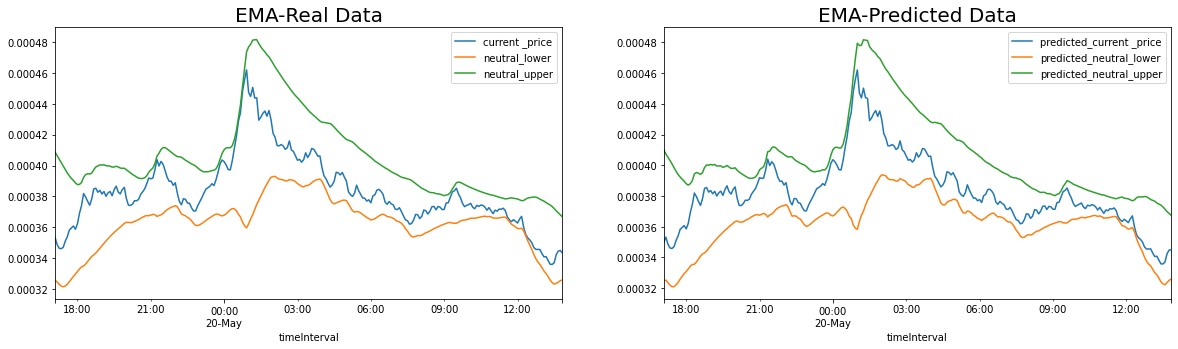

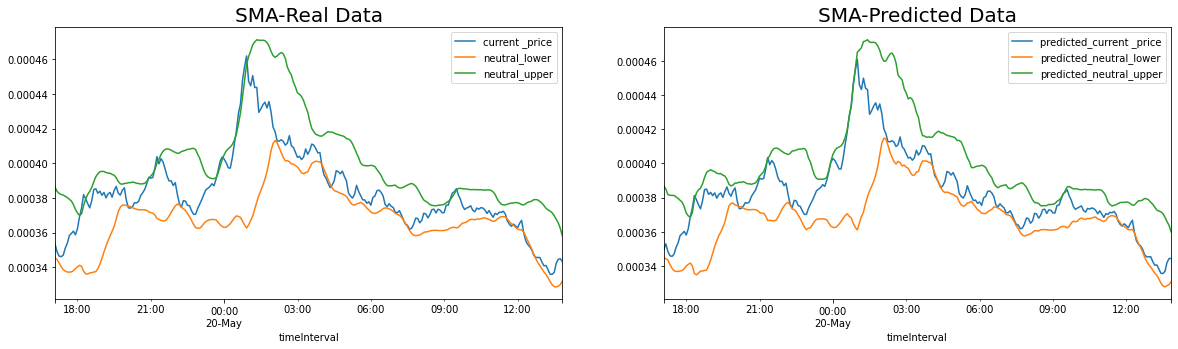

In [8]:
# comparing real & predicted neural bollingerbands for a slice of dataframe

from matplotlib import pyplot

#EMA
fig, (ax1, ax2) =pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(20,5))
data_final_EMA[-250:][['current _price','neutral_lower','neutral_upper']].plot(ax=ax1)
ax1.set_title('EMA-Real Data', fontsize=20)
data_final_EMA[-250:][['predicted_current _price','predicted_neutral_lower','predicted_neutral_upper']].plot(ax=ax2)
ax2.set_title('EMA-Predicted Data', fontsize=20)

#SMA
fig, (ax3, ax4) =pyplot.subplots(ncols=2, sharex=False, sharey=False, figsize=(20,5))
data_final_SMA[-250:][['current _price','neutral_lower','neutral_upper']].plot(ax=ax3)
ax3.set_title('SMA-Real Data', fontsize=20)
data_final_SMA[-250:][['predicted_current _price','predicted_neutral_lower','predicted_neutral_upper']].plot(ax=ax4)
ax4.set_title('SMA-Predicted Data', fontsize=20)

plt.show()

# Conclusion

Based on the above results, the Bollinger bands calculated by Simple Moving Average and predicted by LSTM model is narrower than the ones calculated by Expotential Moving Average.